# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [0]:
from google.colab import drive
drive.mount(mountpoint="content")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content


In [0]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
#from plotly import tools, subplots
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.express as px
#import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold


# --- setup ---
pd.set_option('max_columns', 50)

In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-x74o7rn0
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-x74o7rn0
     |████████████████████████████████| 634kB 7.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=3c70316f86131e13786ce0c4319b4d6861a6c9f91f58ad799dda490c3f27218c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1o8zfcm7/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=cee0295537d27ec5de97df7e722283bbf03ea8ec3b6e2fff1eb9198c40acd524
  Stored in directory: /tmp/pip-ephem-wheel-cache-1o8zfcm7/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [0]:
!git clone https://github.com/KaiyangZhou/pytorch-center-loss

Cloning into 'pytorch-center-loss'...
remote: Enumerating objects: 212, done.
remote: Total 212 (delta 0), reused 0 (delta 0), pack-reused 212
Receiving objects: 100% (212/212), 5.67 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [0]:
cd pytorch-center-loss


/content/pytorch-center-loss


In [0]:
from center_loss import CenterLoss


In [0]:
cd ..

/content


# Config

In [0]:
debug=False
submission=False
batch_size=128
device='cuda:0'
out='.'
image_size=64
n_splits = 5
arch='pretrained'
# model_name='se_resnext101_32x4d'
model_name='se_resnext50_32x4d'
load_model_name = False
load_model_name = 'predictorfold0_centercutout_002.pt'
saved_model_name = 'predictorfold0_centercutout_002.pt'
seed = 42
n_splits = 5
pretrained = "imagenet"

In [0]:
%cd /content/content/My Drive/bengali-ai/kaggle/working

input_path = "/content/content/My Drive/bengali-ai/kaggle/input/"
work_path = "/content/content/My Drive/bengali-ai/kaggle/working/"
datadir = Path(input_path+'bengaliai-cv19')
featherdir = Path(input_path+'bengaliaicv19feather')
outdir = work_path 
load_model_path = outdir +"models/"+ load_model_name if load_model_name else False
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/content/My Drive/bengali-ai/kaggle/working
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_0.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_1.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_2.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/test_image_data_3.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_0.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_1.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_2.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliaicv19feather/train_image_data_3.feather
/content/content/My Drive/bengali-ai/kaggle/input/bengaliai-cv19/class_map.csv
/content/content/My Drive/bengali-ai/kaggle/input/bengaliai-cv19/sample_submission.csv
/c

In [0]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [0]:
#画像前処理
#feather data から　画像データ

In [0]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    #parquet or feather
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    #feather data は４つあるのでconcate
    images = np.concatenate(images, axis=0)
    return images


In [0]:
# os.chdir('/home/chikazoe/operation/bengali/')

In [0]:
%%time
train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=submission, indices=indices)
# train_images.shape (50210, 137, 236) debug
# train_images.shape (200840, 137, 236)"""
#train_fold = pd.read_csv(datadir/'train_with_fold.csv')

image_df_list 4
CPU times: user 8.38 s, sys: 16.4 s, total: 24.8 s
Wall time: 2min 29s


In [0]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax
import cv2
def crop_resize(img0, size=128, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    HEIGHT = 137
    WIDTH = 236
    img0 = 255 - img0
    img0 = (img0*(255.0/img0.max())).astype(np.uint8)
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [0]:
#A = list()
#for i in range(len(train_images)):
#    A.append(crop_resize(train_images[i],128)[None])
#data = np.load("train128.npz")
#data['arr_0'].shape
# train_images = np.load("train128.npz")['arr_0']

Let's see how this `BengaliAIDataset` work

In [0]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [0]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [0]:
train_dataset = BengaliAIDataset(train_images, train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [0]:
image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [0]:
train_dataset.images.shape

(200840, 137, 236)

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

## GridMask

In [0]:
import cv2

import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as FF
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset

class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = FF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [0]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """
    アフィン変換
    max_shear_angleとかmax_scaleがどの程度が最適化かは検討もつかない
    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


def crop_char_image(image, threshold=5./255.):
    """
    余白消し
    
    is_black:[0,0,0,0
              0,1,1,0
              1,0,1,0
              1,0,0,0]
    is_black_horizontal:[0,
                         1,
                         1,
                         1] np.sum(is_black, axis=1)なのでわかりやすい様に縦に並べた
    
    left: 1
    right: 0
    left:height - right: 1:3-0
    cropped_image:[0,1,1,0
                   1,0,1,0
                   1,0,0,0]
    余白をむしろ少しんこすほうがいい可能性もある？
    """
    assert image.ndim == 2
    is_black = image > threshold #黒かどうか、すなわち文字があることの定義
    
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    
    left = np.argmax(is_black_horizontal) 
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]#余白消し
    return cropped_image


def resize(image, size=(64, 64)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

In [0]:
train_images.shape

(200840, 137, 236)

6it [00:00, 184.95it/s]


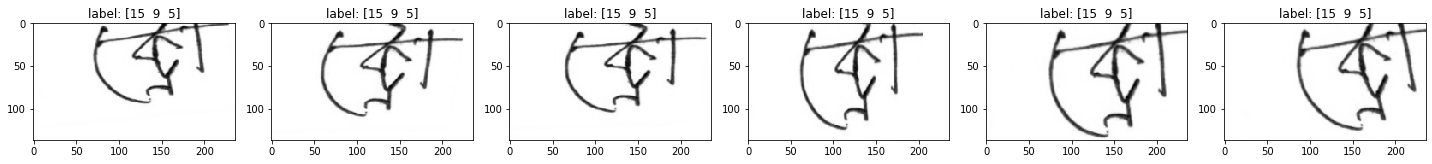

In [0]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

In [0]:
train_dataset.images.shape

(200840, 137, 236)

In [0]:
image.shape

(137, 236)

30it [00:00, 371.27it/s]


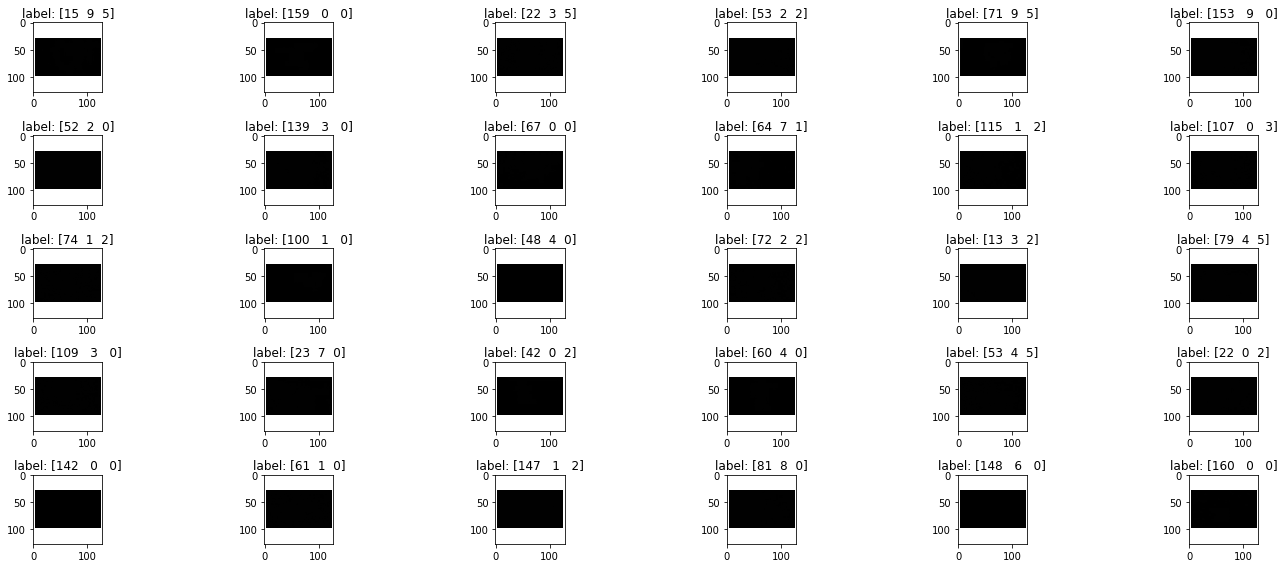

In [0]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(crop_resize(image), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

30it [00:00, 650.42it/s]


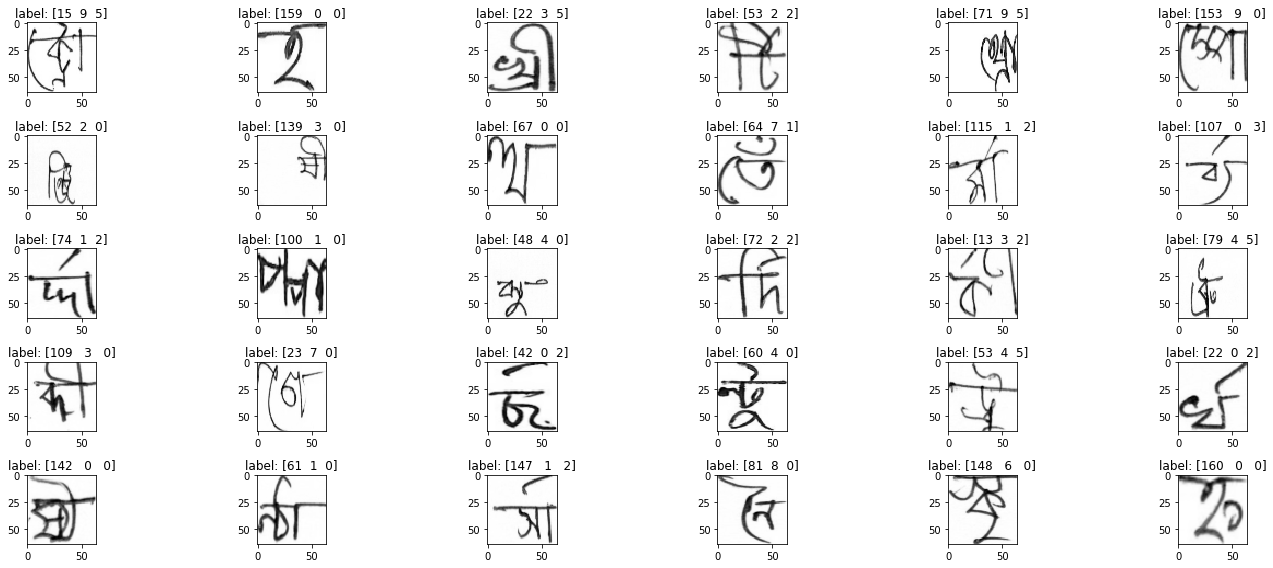

In [0]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

 # data augmentation Transform クラス

この辺りのチューニングは辛そう....学習でチューニングするのは限界あるから　目で見て決めるのかな

In [0]:
import albumentations.augmentations.transforms as A
import albumentations
import numpy as np
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded ,
                           )


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0., gridmask=None):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio
        self.gridmask = gridmask

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...

        

        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(albumentations.imgaug.transforms.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)
        
        if self.gridmask is not None:#追加はじまり
            #print("albumentation変換開始")
            res = self.gridmask(image=x)
            x = res['image'].astype(np.float32)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]

        
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [0]:


train_transform = Transform(
    size=(image_size, image_size), threshold=20,affine=False, crop=True,
    sigma=-1., blur_ratio=0.0, noise_ratio=0.0, cutout_ratio=0.1,
    grid_distortion_ratio=0.0, random_brightness_ratio=0.0,
    piece_affine_ratio=0.05, ssr_ratio=0.0)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

6it [00:00, 68.54it/s]


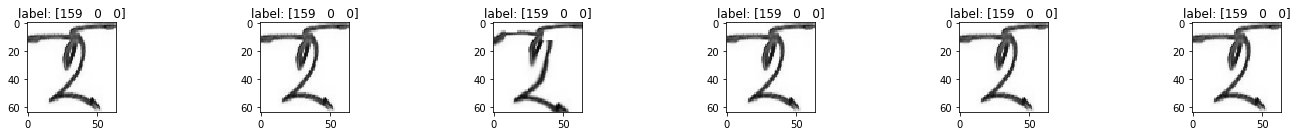

In [0]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[1]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

In [0]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets

30it [00:00, 220.68it/s]


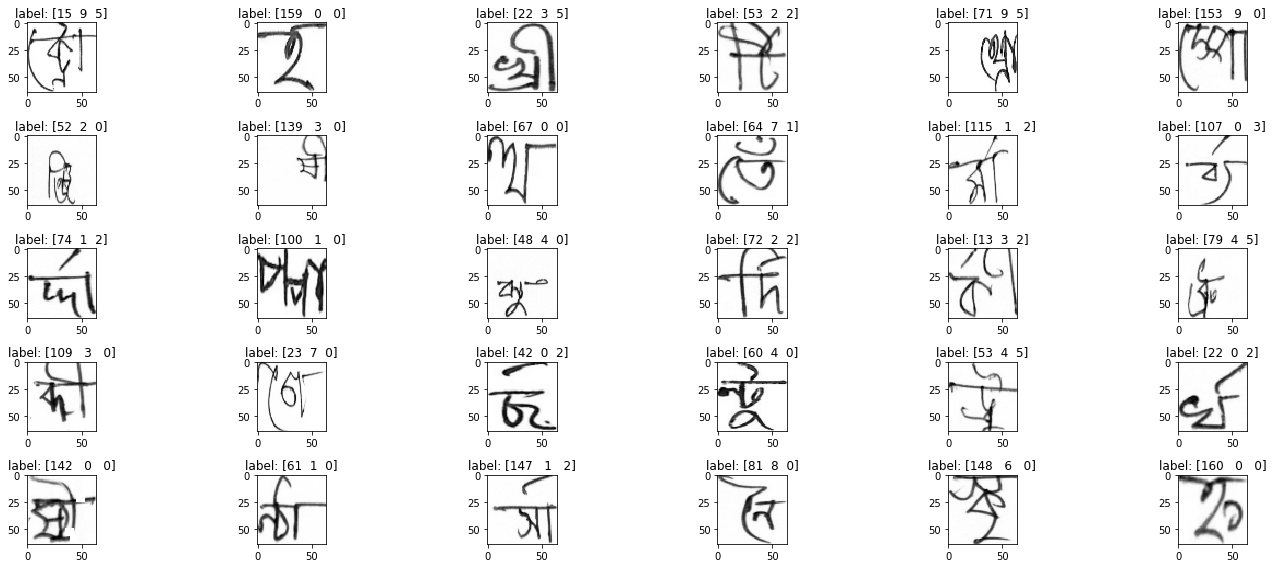

In [0]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [0]:
import torch

#Linear でResnetがやってることをやりたい
def residual_add(lhs, rhs):
    #lhs:linear のアウトプット,rhs:linearのインプット
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:#インプットの方が次元でかいなら削って足す
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        #アウトプットの方が次元ならば、アウトプットを削って足して削った部分をくっつける
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [0]:
#あんまりここは読むいみないと思われる。。。
#nn.Linearは先に入力と出力の次元を決めるけど,動的に決めるLazyLinear書いてる 
#つまりkeras的なことをやりたい
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))

            
            
            
            
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [0]:
from torch import nn
import torch.nn.functional as F
import math

class LinearBlock(nn.Module):
    """
    linear→BN→activation→residual_add→dropout
    """
    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [0]:
# pretrained='imagenet'
# # model_name='se_resnext50_32x4d'
# !pip install ./pretrainedmodels-0.7.4\ 2/pretrainedmodels-0.7.4/ > /dev/null # no output

# import pretrainedmodels

In [0]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [0]:
# import os 
# os.chdir("/home/chikazoe/operation/bengali/")
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=873cb7b1725426e8742d7b9089c164ccbdb598a355cdeb0f187e1be97488ea13
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [0]:
import pretrainedmodels

# model = pretrainedmodels.__dict__[model_name](pretrained=None)

In [0]:
gemm = GeM()

In [0]:
@torch.jit.script
def mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    See additional documentation for mish class.
    '''
    return input * torch.tanh(F.softplus(input))

In [0]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.convgra = nn.Conv2d(
            2048, 2048, kernel_size=3, stride=1, padding=1, bias=False)
        self.convvo = nn.Conv2d(
            2048, 2048, kernel_size=3, stride=1, padding=1, bias=False)
        self.convco = nn.Conv2d(
            2048, 2048, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.batchNgra = nn.BatchNorm2d(2048)
        self.batchNvo = nn.BatchNorm2d(2048)
        self.batchNco = nn.BatchNorm2d(2048)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = mish
        self.gemgra = GeM()
        self.gemvo = GeM()
        self.gemco = GeM()
        self.do_pooling = False
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 1024
        self.lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        self.lin2 = LinearBlock(hdim, 168, use_bn=use_bn, activation=None, residual=False)
        self.lin3 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        self.lin4 = LinearBlock(hdim, 11, use_bn=use_bn, activation=None, residual=False)
        self.lin5 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        self.lin6 = LinearBlock(hdim, 7, use_bn=use_bn, activation=None, residual=False)
        #self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)#self.base_modelはchannelが３を想定しているので1から３に変換
        h = self.base_model.features(h) #imagenetの最後の分類部分(linear)まででなく上層のCNNの部分の結果を取り出す
        h = mish(h)
        grah = self.gemgra(self.batchNgra(self.convgra(h)))
        voh = self.gemvo(self.batchNvo(self.convvo(h)))
        coh = self.gemco(self.batchNco(self.convco(h)))
        
        if self.do_pooling:#謎 平均ではなく足す
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            # [128, 2048, 2, 2] when input is (64, 64)
            bs, ch, height, width = grah.shape
            
            grah = grah.view(bs, ch*height*width)
            voh = voh.view(bs, ch*height*width)
            coh = coh.view(bs, ch*height*width)
        features1 = self.lin1(grah)
        grapheme = self.lin2(features1)
        features2 = self.lin3(voh)
        vowel = self.lin4(features2)
        features3 = self.lin5(coh)
        consonant = self.lin6(features3)
        return features1,grapheme,features2,vowel,features3,consonant

## Classifier

In [0]:
def cutmix_criterion(features,preds1,preds2,preds3, targets,center_loss_grapheme,center_loss_vowel,center_loss_consonant):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    features1,features2,features3 = features[0],features[1],features[2]
    #criterion = FocalLoss(gamma=2,reduced_threshold=0.5)
    
    loss_grapheme = lam *(criterion(preds1, targets1)+center_loss_grapheme(features1, targets1) * 0.0005)
    +(1 - lam) * (criterion(preds1, targets2)+center_loss_grapheme(features1, targets2)* 0.0005)
    loss_vowel = lam * (criterion(preds2, targets3)+center_loss_vowel(features2, targets3) * 0.0005)
    + (1 - lam) * (criterion(preds2, targets4)+center_loss_vowel(features2, targets4) * 0.0005)
    loss_consonant = lam * (criterion(preds3, targets5)+center_loss_consonant(features3, targets5) * 0.0005)
    + (1 - lam) * (criterion(preds3, targets6)+center_loss_consonant(features3, targets6) * 0.0005)
    loss = loss_grapheme*0.5 + loss_vowel*0.25 + loss_consonant*0.25
    return loss,loss_grapheme,loss_vowel,loss_consonant

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor,metric_loss, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor 
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

        
        self.center_loss_grapheme,self.center_loss_vowel,self.center_loss_consonant = metric_loss
    def forward(self, x, y=None,iscutmix=False):
        features1,grapheme,features2,vowel,features3,consonant = self.predictor(x)
        features = [features1,features2,features3]
        #if isinstance(pred, tuple):
        #    assert len(pred) == 3
        #    preds = pred
#
#        else:
#            assert pred.shape[1] == self.n_total_class
#            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        if iscutmix:
            loss,loss_grapheme,loss_vowel,loss_consonant = cutmix_criterion(features,grapheme,vowel,consonant,y,
                                                                           self.center_loss_grapheme,
                                                                           self.center_loss_vowel,
                                                                           self.center_loss_consonant)
            metrics = {
                'loss': loss.item(),
                'loss_grapheme': loss_grapheme.item(),
                'loss_vowel': loss_vowel.item(),
                'loss_consonant': loss_consonant.item(),
                'acc_grapheme': 0,
                'acc_vowel': 0,
                'acc_consonant': 0,
            }
        else:
            loss_grapheme = F.cross_entropy(grapheme, y[:, 0]) + self.center_loss_grapheme(features1, y[:, 0]) * 0.0005
            loss_vowel = F.cross_entropy(vowel, y[:, 1]) + self.center_loss_vowel(features2, y[:, 1]) * 0.0005
            loss_consonant = F.cross_entropy(consonant, y[:, 2]) + self.center_loss_consonant(features3, y[:, 2]) * 0.0005
            loss = loss_grapheme*0.5 + loss_vowel*0.25 + loss_consonant*0.25
            metrics = {
                'loss': loss.item(),
                'loss_grapheme': loss_grapheme.item(),
                'loss_vowel': loss_vowel.item(),
                'loss_consonant': loss_consonant.item(),
                'acc_grapheme': accuracy(grapheme, y[:, 0]),
                'acc_vowel': accuracy(vowel, y[:, 1]),
                'acc_consonant': accuracy(consonant, y[:, 2]),
            }
        return loss, metrics, torch.cat([grapheme,vowel,consonant],dim=1)

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [0]:
torch.split(torch.rand(30,186),[168, 7, 11], dim=1)[0]

tensor([[0.4681, 0.3549, 0.8676,  ..., 0.1530, 0.3563, 0.6890],
        [0.0265, 0.2248, 0.4872,  ..., 0.1585, 0.5605, 0.3319],
        [0.4649, 0.8371, 0.8215,  ..., 0.2282, 0.7143, 0.9640],
        ...,
        [0.9059, 0.2743, 0.7192,  ..., 0.2213, 0.2779, 0.2513],
        [0.0937, 0.4347, 0.9409,  ..., 0.4159, 0.7547, 0.7308],
        [0.3096, 0.1890, 0.0442,  ..., 0.4221, 0.6968, 0.3861]])

In [0]:
torch.cat([torch.rand(30,186),torch.rand(30,186)],dim=1).shape

torch.Size([30, 372])

<a id="train"></a>
# Training code

In [0]:
# train_fold = pd.read_csv("./train_with_fold.csv")
train_labels.shape
def myfunc(num):
    return str(num).zfill(3)
vfunc=np.vectorize(myfunc)
c0 = vfunc(train_labels[:,0]).astype(object)
c1 = vfunc(train_labels[:,1]).astype(object)
c2 = vfunc(train_labels[:,2]).astype(object)
cat_label = c0 + c1 + c2
print(cat_label[:5])
print(len(cat_label))
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
i = 0
for train_index, test_index in skf.split(np.ones(len(cat_label)), cat_label):
    train_idx = train_index
    valid_idx = test_index
    if i == 0:
        break
    i += 1
print(len(train_idx))
print(train_idx[:5])
print(len(valid_idx))
print(valid_idx[:5])

['015009005' '159000000' '022003005' '053002002' '071009005']
200840
160672
[0 1 2 3 4]
40168
[17 19 21 25 27]


## prepare data

In [0]:
#n_dataset = len(train_images)
#train_data_size = 200 if debug else int(n_dataset * 0.9)
#valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)

gridmask = albumentations.Compose([
    albumentations.OneOf([
        GridMask(num_grid=(3,4), mode=0, rotate=15),
        #GridMask(num_grid=(6,7), mode=1),
        #GridMask(num_grid=(6,7), mode=2),
    ], p=0.5)
])

train_transform = Transform(
    size=(image_size, image_size), threshold=20,
    sigma=-1., blur_ratio=0.0, noise_ratio=0.0, cutout_ratio=0.0,
    grid_distortion_ratio=0.0, random_brightness_ratio=0.0,
    piece_affine_ratio=0.0, ssr_ratio=0.0)

valid_trainsform = Transform(affine=False, crop=True, size=(image_size, image_size))

train_dataset = BengaliAIDataset(
    train_images[train_idx], train_labels[train_idx], transform=train_transform)
valid_dataset = BengaliAIDataset(
    train_images[valid_idx], train_labels[valid_idx], transform=valid_trainsform)
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))


train_dataset 160672 valid_dataset 40168


In [0]:
center_loss_grapheme = CenterLoss(num_classes=168, feat_dim=1024, use_gpu=True)
center_loss_vowel = CenterLoss(num_classes=11, feat_dim=1024, use_gpu=True)
center_loss_consonant = CenterLoss(num_classes=7, feat_dim=1024, use_gpu=True)
metric_loss = (center_loss_grapheme,center_loss_vowel,center_loss_consonant)

In [0]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
print("model_name:",model_name,"pretrained:",pretrained)
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# load_model_path = False
if load_model_path:
    predictor.load_state_dict(torch.load(load_model_path))
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor,metric_loss).to(device)


n_total 186
model_name: se_resnext50_32x4d pretrained: imagenet
predictor <class '__main__.PretrainedCNN'>


## Ignite utility

pytorch-ignite utility class for training

### igniteはpytorchのラッパー
ログ周りとかモデル保存周りをきれいに書けるらしい
igniteあたりのコメントは多分どっか間違ってる

### https://fam-taro.hatenablog.com/entry/2018/12/25/021346

In [0]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

In [0]:
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 7.0MB/s 


In [0]:
import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    """
    関数update_fnのreturnから欲しい損失や評価値を撮ってくるための関数
    """
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]

def cutmix_or_mixup_train(images,labels):
    if np.random.rand()<0.2:
        label1, label2, label3 = labels[:,0],labels[:,1],labels[:,2]
        images, targets = cutmix(images, label1, label2, label3, 1)
        return images, targets,True
    elif np.random.rand()<1.1:
        label1, label2, label3 = labels[:,0],labels[:,1],labels[:,2]
        images, targets = mixup(images, label1, label2, label3, 1)
        return images, targets,True
    else:
        return images,labels,False

    

def create_trainer(classifier, optimizer,opt_cen_gr,opt_cen_co,opt_cen_vo, device):
    
    """
    classifier.metrics_keys: 
    ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
    
    """
    classifier.to(device)

    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()
        opt_cen_gr.zero_grad()
        opt_cen_co.zero_grad()
        opt_cen_vo.zero_grad()
        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        
        x,y1,iscutmix = cutmix_or_mixup_train(x,y)
        loss, metrics, pred_y = classifier(x, y1,iscutmix)
        
        loss.backward()
        optimizer.step()
        for param,param2,param3 in zip(center_loss_grapheme.parameters(),center_loss_vowel.parameters(),center_loss_consonant.parameters()):
            param.grad.data *= (1./0.0005)
            param2.grad.data *= (1./0.0005)
            param3.grad.data *= (1./0.0005)
        opt_cen_gr.step()
        opt_cen_co.step()
        opt_cen_vo.step()
        return metrics, pred_y, y
    trainer = Engine(update_fn)# Engine()でtraine.run(loader,epoch)で学習ができる様になる
                                 #Engine(学習関数:update_fn)する学習関数はengineとバッチを引数にする
        

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        #Averageはigniteの平均計算を計算する関数
        #Average().attach(trainer,name)でtrainer(ここではupdate_fn)のアウトプットにnameで名前をつけて平均の監視をする
        #DictOutputTransform(key)によって'loss'や'loss_grapheme'の値を取ってきている
    return trainer


def create_evaluator(classifier, device):
    classifier = classifier.to(device)

    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            _, metrics, pred_y = classifier(x, y,iscutmix=False)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)

    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    """
    'epoch','iteration'metrics
    
    """
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        #自分で追加してLogを取れる
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath+"logs/", 'logcentercutout.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath+"logs/", 'logcentercutout.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    """
    iter/secを計算する
    """
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    """
    モデルの保存
    """
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            #self.logger.warning(f'save model to {filepath}...')

In [0]:
import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float32)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


In [0]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [0]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


optimizer = torch.optim.Adam(classifier.predictor.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-7)

optimizer_centloss_grapheme = torch.optim.Adam(classifier.center_loss_grapheme.parameters(), lr=0.1)
optimizer_centloss_vowel = torch.optim.Adam(classifier.center_loss_vowel.parameters(), lr=0.1)
optimizer_centloss_consonant = torch.optim.Adam(classifier.center_loss_consonant.parameters(), lr=0.1)

scheduler_centloss_grapheme = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_centloss_grapheme, mode='min', factor=0.5, patience=3, min_lr=1e-10)

scheduler_centloss_vowel = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_centloss_vowel, mode='min', factor=0.5, patience=3, min_lr=1e-10)

scheduler_centloss_consonant = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_centloss_consonant, mode='min', factor=0.5, patience=3, min_lr=1e-10)

trainer = create_trainer(classifier,
                         optimizer,
                         optimizer_centloss_grapheme,
                         optimizer_centloss_vowel,
                         optimizer_centloss_consonant,
                         device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)
    schedule_lr(evaluator)
def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    scheduler_centloss_grapheme.step(avg_mae)
    scheduler_centloss_vowel.step(avg_mae)
    scheduler_centloss_consonant.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator) #1epoch終わるごとにrun_evaluatorを実行
#trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir+"logs/")
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor, filepath=outdir +saved_model_name))


In [0]:
trainer.run(train_loader, max_epochs=300)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir+"logs/"+saved_model_name[:-3]+'.csv', index=False)
train_history

In [0]:
import requests

line_notify_token = 'DDKITNfYZlyLUyV9sIZuXte9ms2SuW2cOOMdSPW9nlR'
line_notify_api = 'https://notify-api.line.me/api/notify'
message = 'owari'


payload = {'message': message}
headers = {'Authorization': 'Bearer ' + line_notify_token}  # 発行したトークン
line_notify = requests.post(line_notify_api, data=payload, headers=headers)


<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>